In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

In [14]:
wf_30_var2060=pd.read_csv("data/WF_L030_W1R_TI_High_VEL020_060_fs1000.csv")
wf_60_cte20=pd.read_csv("data/WF_L060_W1R_TI_High_VEL020_fs1000.csv")
wf_30_cte20=pd.read_csv("data/L030_TI_High_VEL020_fs1000.csv")

WF_Sx=(wf_30_cte20,wf_60_cte20,wf_30_var2060)

WF_Sx[0].tail()

,t [s],az NO FLAT [m/s2],az WITH FLAT [m/s2]
26996,32.666,-9.79136,-9.73745
26997,32.667,-9.79432,-9.81700
26998,32.668,-9.79312,-9.74827
26999,32.669,-9.79609,-9.85328
27000,32.670,-9.79480,-9.84643


In [10]:
n1=pd.read_csv("data/Harmonic_n1_W1R_A001_VEL020_fs1000.csv")
n2=pd.read_csv("data/Harmonic_n2_W1R_A001_VEL020_fs1000.csv")
n3=pd.read_csv("data/Harmonic_n3_W1R_A001_VEL020_fs1000.csv")

n1.tail()

,t [s],az NO FLAT [m/s2],az WITH FLAT [m/s2]
8996,32.666,-9.799010,-9.653204
8997,32.667,-9.803764,-9.650483
8998,32.668,-9.798660,-9.654696
8999,32.669,-9.803680,-9.652433
9000,32.670,-9.816648,-9.695604


In [36]:
def gen_G(f_fail, fs, N, Λ=10, D_lambda=1/16):
    K=int(Λ/D_lambda)
    Ts=1/fs
    λs=np.arange(0,Λ,D_lambda)
    G=np.zeros((K,N),dtype=np.complex128)
    for k in range(K):
        G[k,:]=np.exp(-1j*2*np.pi*D_lambda*k*Ts*np.cumsum(f_fail))
    return G

def calc_Xlambda(G, Sx):
    return (1/Sx.shape[0])*np.dot(G, Sx)

def matricial_IGD(f_fail, fs, Sx_env, Λ=10, D_lambda=1/16):
    G=gen_G(f_fail, fs, Sx_env.shape[0], Λ, D_lambda)
    print(Sx_env.shape[0])
    Sx_env=Sx_env-np.mean(Sx_env)
    Sx_env_analytic=signal.hilbert(Sx_env)
    print(Sx_env_analytic.shape[0])
    X_lambda = calc_Xlambda(G, Sx_env_analytic)
    return X_lambda

####  Wheel Flat
##### Index 0: Constant Speed 20 km/h, L=30 mm
##### Index 1: Constant Speed 20 km/h, L=60 mm
##### Index 2: Speed Increases Linearly from 20 to 60 km/h, L=30 mm

In [51]:
index = 0

t = WF_Sx[index]['t [s]'].to_numpy()
az_no_flat = WF_Sx[index]['az NO FLAT [m/s2]'].to_numpy()
az_with_flat = WF_Sx[index]['az WITH FLAT [m/s2]'].to_numpy()

print('Mean az no flat:',np.mean(az_no_flat))
print('Mean az flat:', np.mean(az_with_flat))

az_no_flat = az_no_flat - np.mean(az_no_flat)
az_with_flat = az_with_flat - np.mean(az_with_flat)

fs=1e3
#fs=1/np.mean(np.diff(t))
print('Sampling freq:',fs,'Hz')
N=len(t)
n=np.arange(N)
print('Number of samples:', N)

v=20e3/3600
print('Lineal velocity:',v,'m/s')
r=0.46
print('Radius:',r,'m')
fr=v/(2*np.pi*r)
f_fail=fr*np.ones((N,1))

print('Rotational freq:',fr,'Hz')
print('Initial time:',t[0],'s')

Mean az no flat: -9.809570537387504
Mean az flat: -9.81345842531758
Sampling freq: 1000.0 Hz
Number of samples: 27001
Lineal velocity: 5.555555555555555 m/s
Radius: 0.46 m
Rotational freq: 1.9221611484528422 Hz
Initial time: 5.67 s


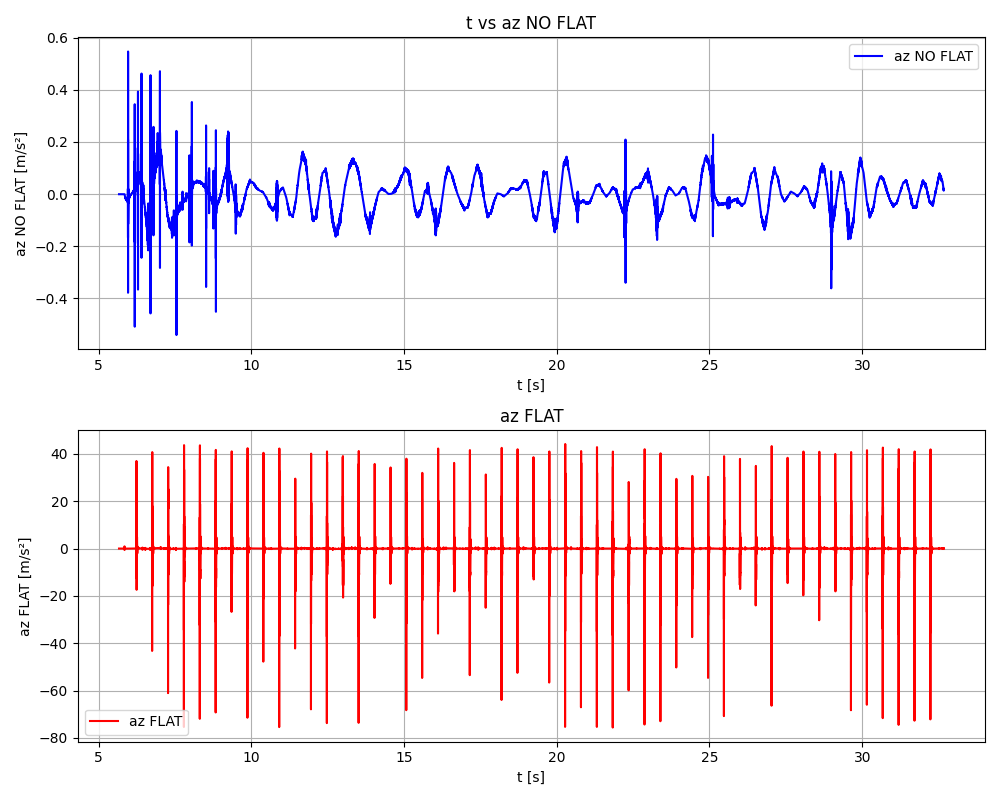

In [52]:
# Crear los subplots
fig, axs = plt.subplots(2, 1, figsize=(10, 8))

# Primer subplot: t vs az_no_flat_array
axs[0].plot(t, az_no_flat, label='az NO FLAT', color='b')
axs[0].set_title('t vs az NO FLAT')
axs[0].set_xlabel('t [s]')
axs[0].set_ylabel('az NO FLAT [m/s²]')
axs[0].grid(True)
axs[0].legend()

# Segundo subplot: az_no_flat_array
axs[1].plot(t,az_with_flat, label='az FLAT', color='r')
axs[1].set_title('az FLAT')
axs[1].set_xlabel('t [s]')
axs[1].set_ylabel('az FLAT [m/s²]')
axs[1].grid(True)
axs[1].legend()

# Ajustar el layout
plt.tight_layout()

# Mostrar los gráficos
plt.show()

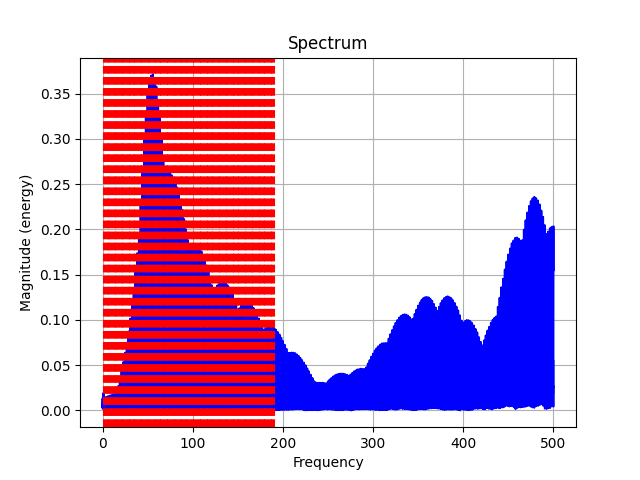

Max freq: 55.77571201066627


In [53]:
plt.close('all')
%matplotlib widget 
plt.title("Spectrum")
spectrum=plt.magnitude_spectrum(az_with_flat, Fs=fs, color='blue')
for i in range(1, 100):
    plt.axvline(x=i*fr, color='red', linestyle='--', label=f'{i}*fr' if i == 1 else None)
plt.grid(True)
plt.show()

print('Max freq:',spectrum[1][np.argmax(spectrum[0])])

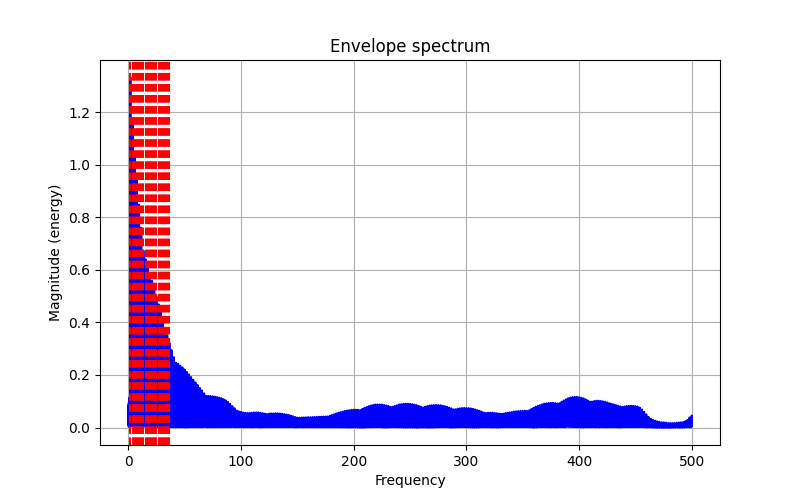

In [54]:
plt.close('all')
Sx_flat_env=np.abs(signal.hilbert(az_with_flat))
%matplotlib widget 
#%matplotlib inline
plt.figure(figsize=(8,5))
plt.title("Envelope spectrum")
spectrum=plt.magnitude_spectrum(Sx_flat_env-np.mean(Sx_flat_env), Fs=fs, color='blue')
for i in range(1, 20):
    plt.axvline(x=i*fr, color='red', linestyle='--', label=f'{i}*fr' if i == 1 else None)
plt.grid(True)
#plt.savefig('prueba_rm.pdf',bbox_inches='tight')
plt.show()

In [55]:
Λ=10
D_lambda=1/16
K=int(Λ/D_lambda)
Ts=1/fs
λs=np.arange(0,Λ,D_lambda)
print('K:',K)
print(len(f_fail))
print(Ts)

K: 160
27001
0.001


In [56]:
G=np.zeros((K,N),dtype=np.complex128)
for k in range(K):
    G[k,:]=np.exp(-1j*2*np.pi*D_lambda*k*Ts*np.cumsum(f_fail))

G.shape

(160, 27001)

In [57]:
Sx_flat_env=Sx_flat_env-np.mean(Sx_flat_env)
Sx_env_analytic=signal.hilbert(Sx_flat_env)
Sx_env_analytic.shape

(27001,)

In [58]:
#X_lambda = (1/N)*np.dot(G, Sx_env_analytic)
X_lambda = calc_Xlambda(G,Sx_env_analytic)

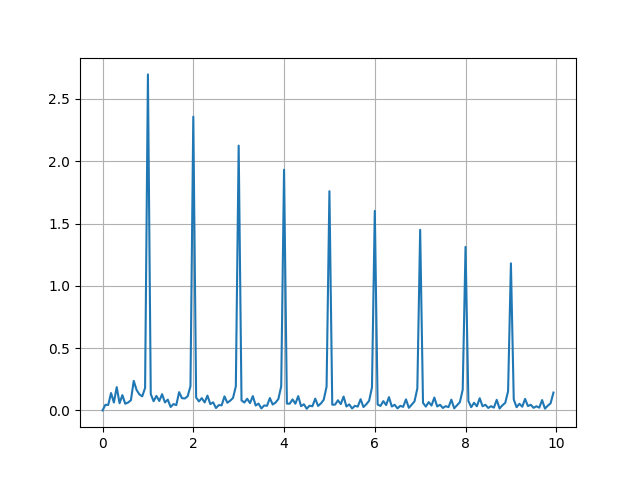

In [59]:
plt.close('all')
%matplotlib widget

plt.plot(λs,np.abs(X_lambda))
plt.grid(True)

---

In [49]:
index = 0

t = WF_Sx[index]['t [s]'].to_numpy()
az_no_flat = WF_Sx[index]['az NO FLAT [m/s2]'].to_numpy()
az_with_flat = WF_Sx[index]['az WITH FLAT [m/s2]'].to_numpy()

az_no_flat = az_no_flat - np.mean(az_no_flat)
az_with_flat = az_with_flat - np.mean(az_with_flat)

fs=1e3
N=len(t)
n=np.arange(N)

if index < 2:
    v=20e3/3600
    r=0.46
    fr=v/(2*np.pi*r)
    f_fail=fr*np.ones((N,1))
else:
    pass

Sx_flat_env=np.abs(signal.hilbert(az_with_flat))


In [50]:
X_lambda_0 = matricial_IGD(f_fail, fs, Sx_flat_env)

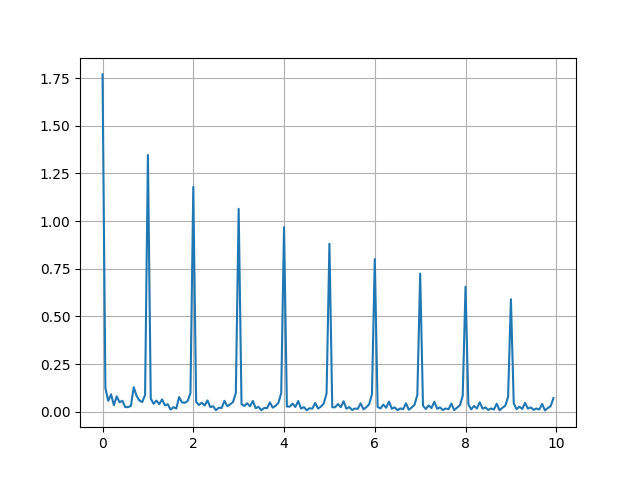

In [48]:
plt.close('all')
%matplotlib widget

λs=np.arange(0,Λ,D_lambda)

plt.plot(λs,np.abs(X_lambda_0))
plt.grid(True)